In [2]:
import os, sys, subprocess
from pyspark.sql import SparkSession

# garante que Spark vai usar o mesmo Python do driver
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

# se já tiver Spark rodando, para
prev = SparkSession.getActiveSession()
if prev is not None:
    prev.stop()

# cria sessão Spark
spark = (
    SparkSession.builder
    .master("local[*]")
    .appName("Bronze-Analytics")
    .config("spark.driver.extraJavaOptions", "-Djava.security.manager=allow")
    .config("spark.executor.extraJavaOptions", "-Djava.security.manager=allow")
    .getOrCreate()
)

spark.sparkContext.setLogLevel("ERROR")
print("Spark OK =>", spark.version)


25/09/24 17:39:03 WARN Utils: Your hostname, MacBook-Air-de-Kaleb.local resolves to a loopback address: 127.0.0.1; using 192.168.1.8 instead (on interface en0)
25/09/24 17:39:03 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/09/24 17:39:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/09/24 17:39:03 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


Spark OK => 3.5.1


----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 56023)
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.11/3.11.13/Frameworks/Python.framework/Versions/3.11/lib/python3.11/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/opt/homebrew/Cellar/python@3.11/3.11.13/Frameworks/Python.framework/Versions/3.11/lib/python3.11/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/opt/homebrew/Cellar/python@3.11/3.11.13/Frameworks/Python.framework/Versions/3.11/lib/python3.11/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/opt/homebrew/Cellar/python@3.11/3.11.13/Frameworks/Python.framework/Versions/3.11/lib/python3.11/socketserver.py", line 755, in __init__
    self.handle()
  File "/opt/homebrew/lib/python3.11/site-packages/pyspark/ac

In [3]:
from pyspark.sql import functions as F

RAW_DIR = "/Users/kalebmacedo/formula1-analytics-1/bronze/dados_originais"

results      = spark.read.csv(f"{RAW_DIR}/results.csv", header=True, inferSchema=True)
constructors = spark.read.csv(f"{RAW_DIR}/constructors.csv", header=True, inferSchema=True)
status       = spark.read.csv(f"{RAW_DIR}/status.csv", header=True, inferSchema=True)
races        = spark.read.csv(f"{RAW_DIR}/races.csv", header=True, inferSchema=True)

# Sanity rápido
print(results.count(), "linhas em results")
print(constructors.count(), "linhas em constructors")
print(status.count(), "linhas em status")
print(races.count(), "linhas em races")


26759 linhas em results
212 linhas em constructors
139 linhas em status
1125 linhas em races


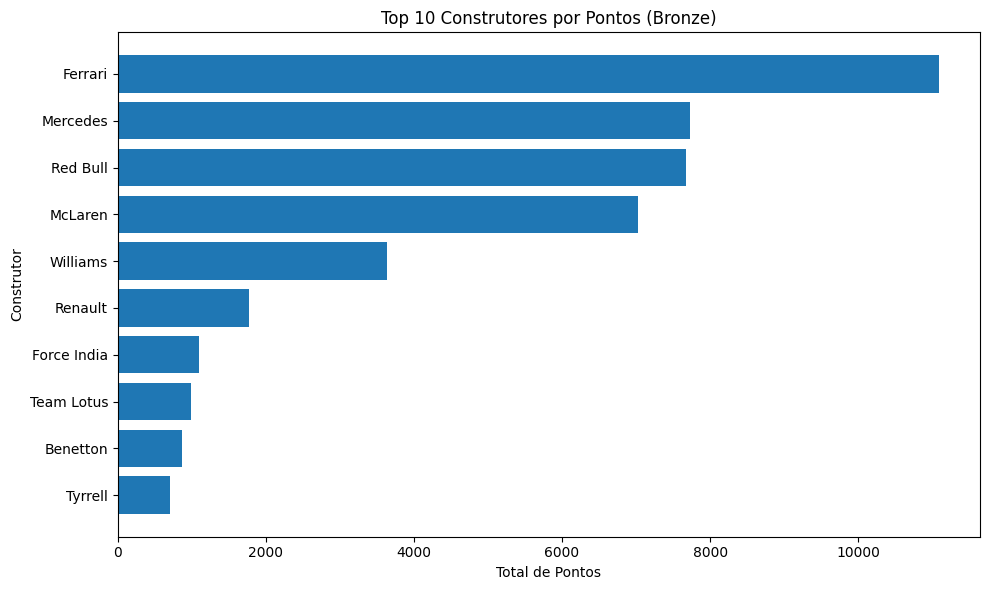

In [4]:
# agregação 100% PySpark
top_points = (results
    .groupBy("constructorId")
    .agg(F.sum(F.col("points").cast("double")).alias("total_points"))
    .join(constructors.select("constructorId","name"), on="constructorId", how="left")
    .orderBy(F.desc("total_points"))
    .limit(10)
    .select("name","total_points"))

# coletar para listas Python
rows   = top_points.collect()
labels = [r["name"] or "N/A" for r in rows]
values = [float(r["total_points"]) for r in rows]

# desenhar com matplotlib (sem seaborn/pandas)
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.barh(labels, values)               # barras horizontais como no print
plt.gca().invert_yaxis()               # maior em cima
plt.title("Top 10 Construtores por Pontos (Bronze)")
plt.xlabel("Total de Pontos"); plt.ylabel("Construtor")
plt.tight_layout(); plt.show()


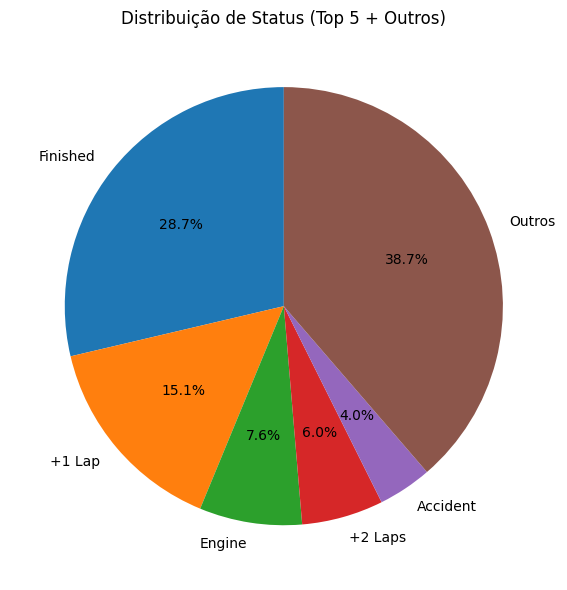

In [5]:
# contagem por statusId
st_counts = (results
    .groupBy("statusId").count()
    .join(status, on="statusId", how="left")        # traz a descrição textual
    .withColumn("status", F.coalesce(F.col("status"), F.lit("Desconhecido")))
    .orderBy(F.desc("count")))

# Top 5 + Outros em PySpark
top5   = st_counts.limit(5)
sum5   = top5.agg(F.sum("count")).first()[0]
sumAll = st_counts.agg(F.sum("count")).first()[0]
outros = int(sumAll - sum5)

rows5   = top5.select("status","count").collect()
labels  = [r["status"] for r in rows5]
sizes   = [int(r["count"]) for r in rows5]
if outros > 0:
    labels.append("Outros"); sizes.append(outros)

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=90)
plt.title("Distribuição de Status (Top 5 + Outros)")
plt.tight_layout(); plt.show()


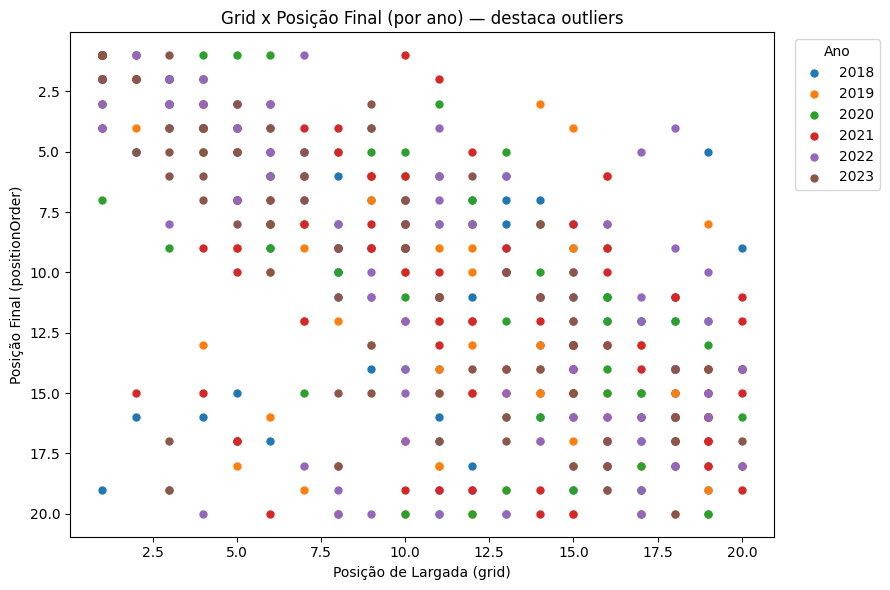

In [6]:
# selecionar colunas e juntar o ano da corrida
res_year = (results
    .select("raceId", "grid", "positionOrder")
    .join(races.select("raceId","year"), on="raceId", how="left")
    .withColumn("grid", F.col("grid").cast("int"))
    .withColumn("positionOrder", F.col("positionOrder").cast("int"))
    .withColumn("year", F.col("year").cast("int"))
    .filter(F.col("grid").isNotNull() & F.col("positionOrder").isNotNull() & F.col("year").isNotNull())
    .filter((F.col("grid")>0) & (F.col("positionOrder")>0))  # remove zeros/NA padrão da fonte
)

# opcional: limitar a janela de anos e/ou amostrar para o gráfico ficar legível
res_year_sample = (res_year
    .filter((F.col("year") >= 2018) & (F.col("year") <= 2023))  # ajuste como quiser
    .sample(withReplacement=False, fraction=0.2, seed=42))      # ~20% dos pontos p/ não poluir

# coletar por categoria (ano) -> listas para plot
groups = (res_year_sample
          .groupBy("year")
          .agg(F.collect_list("grid").alias("xs"),
               F.collect_list("positionOrder").alias("ys"))
          .orderBy("year")
          .collect())

plt.figure(figsize=(9,6))
for g in groups:
    xs, ys = list(map(int, g["xs"])), list(map(int, g["ys"]))
    plt.scatter(xs, ys, s=25, label=str(g["year"]))   # um "hue" por ano

plt.gca().invert_yaxis()  # posição 1 (vencedor) no topo
plt.title("Grid x Posição Final (por ano) — destaca outliers")
plt.xlabel("Posição de Largada (grid)")
plt.ylabel("Posição Final (positionOrder)")
plt.legend(title="Ano", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout(); plt.show()
